# Rover Project - Test Notebook
The purpose of this notebook is to test and play with the hyper-parameters of the different functions used in this project.

Below are the sections included in this notebook:  

`1.` [Importing some packages and modules.](#cell1)  
`2.` [Making sure that everything works by displaying some images.](#cell2)  
`3.` [Color thresholding.](#cell3)  
`4.` [Perspective transformation.](#cell4)  
`5.` [Coordinate transformations.](#cell5)  
`6.` [Making a custom data class.](#cell6)  
`7.` [Combining the above functions into a bigger one.](#cell7)  
`8.` [Processing sample images and merging them into a video.](#cell8)  
`9.` [Displaying the created video.](#cell9)  
`10.` [Simulating the process when accepting a video as input](#cell10)  
&nbsp;&nbsp;&nbsp;&nbsp; `10.1.` [Creating a dummy video (as if the user provided it along with the navigation data).](#cell10_1)  
&nbsp;&nbsp;&nbsp;&nbsp; `10.2.` [Extracting frame images from the provided (in our case, dummy) video.](#cell10_2)  
&nbsp;&nbsp;&nbsp;&nbsp; `10.3.` [Processing extracted frame images then merging them into a video.](#cell10_3)  
&nbsp;&nbsp;&nbsp;&nbsp; `10.4.` [Displaying the processed video from the input one.](#cell10_4)  

## `1.` Importing some packages and modules
<a id="cell1"></a>

In [1]:
import cv2
import numpy as np
import matplotlib.image  as mimg
import matplotlib.pyplot as mplot
import os.path

# Next line is used to display and store Matplotlib plots directly in the notebook.
# The output of plotting commands is displayed inline, below the code cell that produced it.
# The resulting plots will then also be stored in the notebook document.
%matplotlib inline

## `2.` Making sure everything works by displaying some images
<a id="cell2"></a>

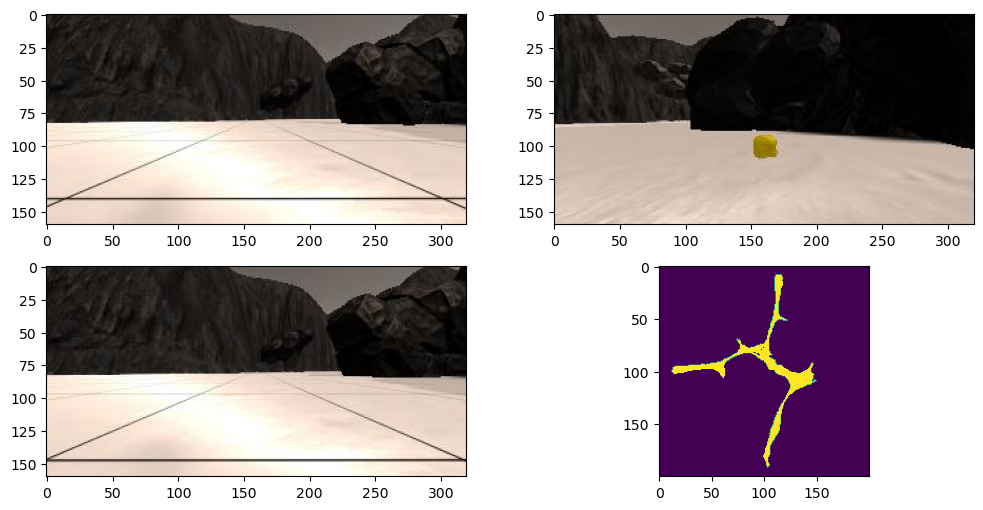

In [2]:

imgs_relative_loc = "../calibration_images"
mplot.figure(figsize=(12, 6))
mplot.subplot(2, 2, 1) # or "221" >> 2 rows, 2 columns, subplot (No.1).
mplot.imshow(mimg.imread(os.path.join(imgs_relative_loc, "example_grid1.jpg")))
mplot.subplot(2, 2, 2)
mplot.imshow(mimg.imread(os.path.join(imgs_relative_loc, "example_rock1.jpg")))
mplot.subplot(2, 2, 3)
mplot.imshow(mimg.imread(os.path.join(imgs_relative_loc, "example_grid2.jpg")))
mplot.subplot(2, 2, 4)
mplot.imshow(mimg.imread(os.path.join(imgs_relative_loc, "map_bw.png")))

## `3.` Color thresholding
We want to identify the pixles that are within a given range in all the color channels. The output will be a mask with the same shape as the input image, with ones in the places where there are identified pixels.
<a id="cell3"></a>

In [3]:
def color_thresh(img, rgb_thresh_min=(160, 160, 160), rgb_thresh_max=(255, 255, 255)):
    # This gives a list of zeros and ones representing the identified pixels.
    identified_pixels = (img[:, :, 0] > rgb_thresh_min[0]) \
                    &   (img[:, :, 1] > rgb_thresh_min[1]) \
                    &   (img[:, :, 2] > rgb_thresh_min[2]) \
                    \
                    &   (img[:, :, 0] <= rgb_thresh_max[0]) \
                    &   (img[:, :, 1] <= rgb_thresh_max[1]) \
                    &   (img[:, :, 2] <= rgb_thresh_max[2])
    
    # Create a mask with the same shape as the input image.
    img_mask = np.zeros_like(img[:, :, 0])
    
    # Go through the image mask and set the pixels that are identified to 1.
    img_mask[identified_pixels] = 1
    
    return img_mask

## `4.` Perspective transformation
Some useful links:
* [cv2.getPerspectiveTransform()](https://theailearner.com/tag/cv2-getperspectivetransform/)
* [4 Point OpenCV getPerspective Transform Example](https://medium.com/analytics-vidhya/opencv-perspective-transformation-9edffefb2143)
* [OpenCv Perspective Transformation](https://pyimgsearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/)
* [What is Perspective Warping? | OpenCV and Python](https://pub.towardsai.net/what-is-perspective-warping-opencv-and-python-750e7a13d386)
<a id="cell4"></a>

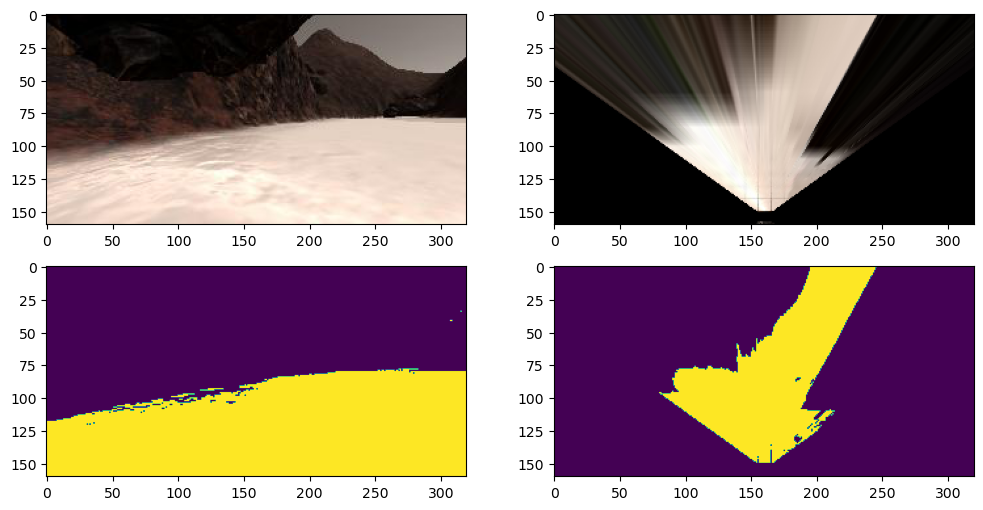

In [4]:
def perspect_transform(img, src, dst):
    # Get a transformation matrix using the corners of the desired image section (in our case,
    # the corners of square grid) and a matrix containting the new image corner pixels.
    trans_matrix = cv2.getPerspectiveTransform(src, dst)
    
    # Inputs are: [`The original image`, `transformation matrix`, `the (height (y), width (x)) of the output image`]
    # Since we want to keep same size of the input image, we need to pass its shape.
    return cv2.warpPerspective(img, trans_matrix, (img.shape[1], img.shape[0]))


## Testing the above function!
# Define a source and a destination points for the perspective transformation.
# The pixel coordinates below are found by opening `example_grid1.jpg` with paint and hovering over the grid corners.
# This variable holds the locations of the gird corners (for calibration). Corners order: [(B)ottom (L)eft, BR, TR, TL]
source = np.float32([[14, 140], [301, 140], [200, 96], [118, 96]])

# Get a random image.
dataset_images = os.listdir("../test_dataset/IMG/")
image = mimg.imread(os.path.join("../test_dataset/IMG/",
                    dataset_images[np.random.randint(0, len(dataset_images)-1)]))

# The input image will be warped to a grid where each 10x10 pixels (square) represent 1 square meter.
dst_size = 5

# Define an offset from the bottom of the image.
btm_offset = 10

destination = np.float32([
                            # BL corner => Y-size center - dst_size, X-size - btm_offset
                            [image.shape[1]/2 - dst_size, image.shape[0] - btm_offset],
                            # BR corner => Y-size center + dst_size, X-size - btm_offset
                            [image.shape[1]/2 + dst_size, image.shape[0] - btm_offset],
                            # TR corner => Y-size center + dst_size, X-size - 2*dst_size - btm_offset
                            [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - btm_offset],
                            # TL corner => Y-size center - dst_size, X-size - 2*dst_size - btm_offset
                            [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - btm_offset]
                        ])


# Get the grid image.
grid_img = mimg.imread("../calibration_images/example_grid1.jpg")

# Perform perspective transformation.
warped = perspect_transform(grid_img, source, destination)

# Perfrom thresholding on the original and warped images.
image_threshed = color_thresh(image)
warped_threshed = color_thresh(warped)

# Plotting images.
mplot.figure(figsize=(12, 6))
mplot.subplot(2, 2, 1)
mplot.imshow(image)
mplot.subplot(2, 2, 2)
mplot.imshow(warped)
mplot.subplot(2, 2, 3)
mplot.imshow(image_threshed)
mplot.subplot(2, 2, 4)
mplot.imshow(warped_threshed)

## `5.` Coordinate transformations
We need to define the next functions:
* `rover_coords(img)`:
  Transforms image coordinates to Rover coordinates.
* `to_polar_coords(x_pixel, y_pixel)`:
  Converts points `(x, y)` in rover space to polar coordinates `(distance, angle)`
* `totate_pix(xpix, ypix, yaw)`:
  Transform pixels in rover space to world space.
* `translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)`:
  Apply translation with scaling.
* `pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale)`:
  Apply multiple transformations [`rotation`, `translation`, `clipping`].
<a id="cell5"></a>

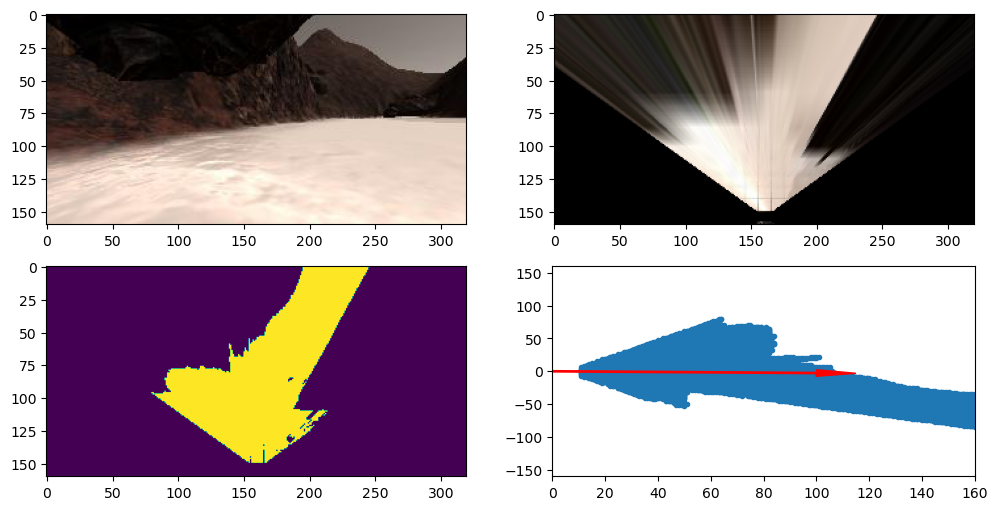

In [5]:
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    
    # Determine pixel positions relative to the rover position (being at the center bottom of the image).
    x_pixel = -(ypos - binary_img.shape[0]).astype(float)
    y_pixel = -(xpos - binary_img.shape[1]/2).astype(float)
    return x_pixel, y_pixel

def to_polar_coords(x_pixel, y_pixel):
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    
    # For each pixel, calculate the angle between it and the vertical axis.
    angles = np.arctan2(y_pixel, x_pixel)
    
    return dist, angles

def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    
    # Apply rotation by multiplying the image by the 2D rotation matrix.
    # Rotation matrix: [x`, y`] = [cos(x) -sin(y); sin(x) cos(y)][x; y]
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale):
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    
    return xpix_translated, ypix_translated

def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    
    return x_pix_world, y_pix_world

## Testing the above functions!
# Transform warped_threshed image to rover coordinates then get the polar coordinates.
xpix, ypix = rover_coords(warped_threshed)
dist, angles = to_polar_coords(xpix, ypix)

# Direction is the average of all the angle values of the pixels
mean_dir = np.mean(angles)

# Plotting images.
mplot.figure(figsize=(12, 6))
mplot.subplot(2, 2, 1)
mplot.imshow(image)
mplot.subplot(2, 2, 2)
mplot.imshow(warped)
mplot.subplot(2, 2, 3)
mplot.imshow(warped_threshed)
mplot.subplot(2, 2, 4)
mplot.plot(xpix, ypix, '.')
mplot.ylim(-160, 160)
mplot.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
mplot.arrow(0, 0, x_arrow, y_arrow, color="red", zorder=2, head_width=10, width=2)

In [6]:
num_angles = len(angles[angles >= 0])
print(num_angles)
print(len(angles) - num_angles)
print(len(angles[angles < 0]))
print(angles)
print(np.mean(angles))
print(np.mean(np.sort(angles)[int(len(angles)/2):]))
print(np.sort(angles))
print(np.sort(angles)[-int(len(angles)/2):])
print(np.sort(angles)[int(len(angles)/2):])
print(np.mean(angles * 180/np.pi))
print(np.clip(np.mean(angles * 180/np.pi), -15, 15))
print(np.clip(66, -15, 15))
print(np.clip(-66, -15, 15))

3939
6133
6133
[-0.2153577  -0.22131444 -0.22725526 ... -0.348771   -0.49934672
 -0.56672922]
-0.026708947550209822
0.31940454618011427
[-0.85196633 -0.84415399 -0.84247895 ...  0.89605538  0.89605538
  0.89760098]
[-0.16514868 -0.16514868 -0.16514868 ...  0.89605538  0.89605538
  0.89760098]
[-0.16514868 -0.16514868 -0.16514868 ...  0.89605538  0.89605538
  0.89760098]
-1.5303099698633045
-1.5303099698633045
15
-15


## `6.` Making a custom data class
<a id="cell6"></a>

In [7]:
import pandas as pd

# Load the world map image.
ground_truth = mimg.imread("../calibration_images/map_bw.png")

# Generate an image with 3 channels based on the ground truth for plotting purposes.
# Set both red and blue channels to 0 and green channel to 255.
ground_truth_3 = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(float)

# Creating a custom data class for holding telemetry data.
class DataContainer():
    def __init__(self, csv_file_loc="../test_dataset/robot_log.csv", images_loc="../test_dataset/IMG/"):
        # Read the robot_log.csv file and store its data in a variable.
        csv_logs = pd.read_csv(csv_file_loc, delimiter=";", decimal=".")
        self.images = [os.path.join(images_loc, i) for i in os.listdir(images_loc)]
        self.xpos = csv_logs["X_Position"].values
        self.ypos = csv_logs["Y_Position"].values
        self.yaw = csv_logs["Yaw"].values
        self.count = 0
        # Worldmap is 200x200 pixels (same size as the ground truth map).
        self.worldmap = np.zeros((200, 200, 3)).astype(float)
        self.ground_truth = ground_truth_3

# Instantiating the DataContainer class.
data = DataContainer()

## `7.` Combining the above functions into a bigger one
`Next are the steps that we are going to perform:`  
`1.` Defining a source and a destination coordinates for the perspective transformation.  
`2.` Applying perspective transformation.  
`3.` Applying color thresholding to identify navigable terrain, obstacles (wall), and rocks/samples.  
`4.` Converting the thresholded images to rover coordinates.  
`5.` Convert rover coordinates to world coordinates.  
`6.` Update world map.  
`7.` Combining the original image, warped version, and the world map into one image (For visualization only).
<a id="cell7"></a>

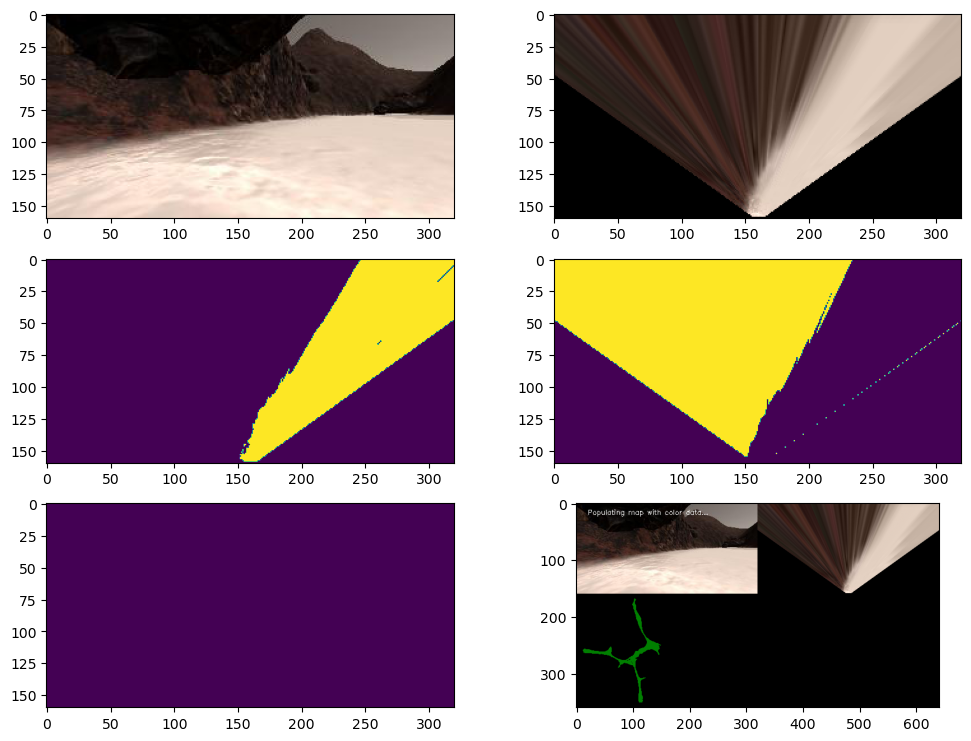

In [8]:
def process_image(img, Plotting=False):
    # 1) Defining a source and a destination coordinates for the perspective transformation.
    # source = np.float32([[14, 140], [301, 140], [200, 96], [118, 96]]) # (B)ottom (L)eft, BR, TR, TL
    source = np.float32([[118, 96], [200, 96], [301, 140], [14, 140]])   # (T)op (L)eft, TR, BR, BL
    
    # The input image will be warped to a grid where each 10x10 pixels (square) represent 1 square meter.
    dst_size = 5
    
    destination = np.float32([[155, 148], [165, 148], [165, 158], [155, 158]])
    
    # # Define an offset from the bottom of the image.
    # btm_offset = 10
    # # grid_img.shape = (160, 320, 3)
    # # grid_img.shape[1]/2 - dst_size = 155 | grid_img.shape[0]              - bottom_offset = 150
    # # grid_img.shape[1]/2 + dst_size = 165 | grid_img.shape[0] - 2*dst_size - bottom_offset = 140
    # Therefore => destination = [[155, 150], [165, 150] , [165, 140], [155, 140]]
    # destination = np.float32([
    #                             # BL corner => Y-size center - dst_size, X-size - btm_offset
    #                             [img.shape[1]/2 - dst_size, img.shape[0] - btm_offset],
    #                             # BR corner => Y-size center + dst_size, X-size - btm_offset
    #                             [img.shape[1]/2 + dst_size, img.shape[0] - btm_offset],
    #                             # TR corner => Y-size center + dst_size, X-size - 2*dst_size - btm_offset
    #                             [img.shape[1]/2 + dst_size, img.shape[0] - 2*dst_size - btm_offset],
    #                             # TL corner => Y-size center - dst_size, X-size - 2*dst_size - btm_offset
    #                             [img.shape[1]/2 - dst_size, img.shape[0] - 2*dst_size - btm_offset]
    #                         ])
    
    
    # 2) Applying perspective transformation.
    warped = perspect_transform(img, source, destination)
    
    # 3) Applying color thresholding to identify navigable terrain, obstacles (wall), and rocks/samples.
    nav_terrain_threshed = color_thresh(warped)
    obs_threshed = color_thresh(warped, rgb_thresh_min=(0, 0, 0), rgb_thresh_max=(160, 160, 160))
    # Rocks are bright in red and green channels, and dim in the blue channel.
    rock_threshed = color_thresh(warped, rgb_thresh_min=(150, 100, 0), rgb_thresh_max=(255, 200, 50))
    
    # 4) Converting the thresholded images to rover coordinates.
    xpix, ypix = rover_coords(nav_terrain_threshed)
    obs_xpix, obs_ypix = rover_coords(obs_threshed)
    rock_xpix, rock_ypix = rover_coords(rock_threshed)
    
    # 5) Convert rover coordinates to world coordinates.
    xpos, ypos = data.xpos[data.count], data.ypos[data.count]
    yaw = data.yaw[data.count]
    world_size = data.worldmap.shape[0]
    scale = 2 * dst_size
    x_world, y_world = pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale)
    obs_x_world, obs_y_world = pix_to_world(obs_xpix, obs_ypix, xpos, ypos, yaw, world_size, scale)
    rock_x_world, rock_y_world = pix_to_world(rock_xpix, rock_ypix, xpos, ypos, yaw, world_size, scale)
    
    # 6) Update world map.
    # Set blue channel to 255 where there is navigable terrain.
    data.worldmap[y_world, x_world, 2] += 1
    # Set red channel to 255 where there are obstacles.
    data.worldmap[obs_y_world, obs_x_world, 0] += 1
    
    # If blue channel > 0, set red channel to 0.
    nav_pix = data.worldmap[:, :, 2] > 0
    data.worldmap[nav_pix, 0] = 0
    
    # Check for rocks and set green channel to 255 where there are.
    if rock_threshed.any():
        # Set red and blue channels to 0 where there is a rock pixel.
        data.worldmap[rock_y_world, rock_x_world, 0::2] = 0
        data.worldmap[rock_y_world, rock_x_world, 1] = 255
    
    # 7) Combining the original image, warped version, and the world map into one image (For visualization only).
    # Creating a blank matrix to hold the images.
    merged_output = np.zeros(   # Image (x) size + world map (x) size, and twice the image (y) size.
                                (img.shape[0] + data.worldmap.shape[0],
                                 img.shape[1]*2, 3)
                            )
    # Insert the original image into the top left corner of the output image.
    merged_output[0:img.shape[0], 0:img.shape[1]] = img
    
    # Insert the warped image into the top right corner of the output image.
    merged_output[0:img.shape[0], img.shape[1]:] = warped
    
    # Overlay worldmap with ground truth map.
    worldmap_overlay = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
    
    # Add the worldmap overlay to the output image after flipping it upside-down.
    merged_output[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(worldmap_overlay)
    
    # Overlay some text on the output image.
    cv2.putText(merged_output, "Populating map with color data...", (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
    
    # Increment the count.
    if data.count < len(data.images) - 1:
        data.count += 1
    
    if Plotting:
        mplot.figure(figsize=(12, 9))
        mplot.subplot(3, 2, 1)
        mplot.imshow(img)
        mplot.subplot(3, 2, 2)
        mplot.imshow(warped)
        mplot.subplot(3, 2, 3)
        mplot.imshow(nav_terrain_threshed)
        mplot.subplot(3, 2, 4)
        mplot.imshow(obs_threshed)
        mplot.subplot(3, 2, 5)
        mplot.imshow(rock_threshed)
        mplot.subplot(3, 2, 6)
        
        # Why dividing by 255? Because the datatype of merged_image is float. If a float image is passed to matplotlib, it expects
        # the pixels to have values from 0 to 1. If an int image is passed, pixels are expected to have values from 0 to 255.
        # Source: https://stackoverflow.com/questions/49643907/clipping-input-data-to-the-valid-range-for-imshow-with-rgb-data-0-1-for-floa
        mplot.imshow(merged_output/255)
    return merged_output

## Testing the above functions!
merged_image = process_image(image, True)

## `8.` Processing sample images and merging them into a video
<a id="cell8"></a>

In [9]:
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip

# Define the output video file path.
output = "../output/processed-dataset.mp4"

# Re-instantiating the data object.
data = DataContainer()

clip = ImageSequenceClip(data.images, fps=60)

new_clip = clip.fl_image(process_image)
%time new_clip.write_videofile(output, audio=False)

Moviepy - Building video ../output/processed-dataset.mp4.
Moviepy - Writing video ../output/processed-dataset.mp4



Moviepy - Done !
Moviepy - video ready ../output/processed-dataset.mp4
CPU times: user 2.01 s, sys: 68 ms, total: 2.07 s
Wall time: 2.26 s


## `9.` Displaying the created video
<a id="cell9"></a>

In [10]:
from IPython.display import Video

# Displaying a video directly in the notebook.
Video(output, embed=True)

## `10.` Simulating the process when accepting a video as input

The purpose of this section is to show how to accept a video along with navigation data, convert its frames into images, process these images with the data, and finally convert the frames back into a video.
<a id="cell10"></a>

 ### `10.1.` Creating a dummy video (as if the user provided it along with the navigation data)
 <a id="cell10_1"></a>

In [11]:
# Define the path to store the dummy video.
output = "../test_dataset/dummy-video.mp4"

clip = ImageSequenceClip(data.images, fps=60)
%time clip.write_videofile(output, audio=False)

Moviepy - Building video ../test_dataset/dummy-video.mp4.
Moviepy - Writing video ../test_dataset/dummy-video.mp4



Moviepy - Done !
Moviepy - video ready ../test_dataset/dummy-video.mp4
CPU times: user 311 ms, sys: 477 µs, total: 311 ms
Wall time: 456 ms


### `10.2.` Extracting frame images from the provided (in our case, the dummy) video
<a id="cell10_2"></a>

In [12]:
vidcap = cv2.VideoCapture(output)
success,image = vidcap.read()
count = 0
while success:
  # save each frame as a JPEG file.
  cv2.imwrite("../test_dataset/dummy-video-frames/frame%d.jpg" % count, image)
  success,image = vidcap.read()
  count += 1

### `10.3.` Processing extracted frame images then merging them into a video
<a id="cell10_3"></a>

In [13]:
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip

# Define the output video file path.
output = "../output/dummy_video_processed.mp4"

# Re-instantiating the data object. Make sure to use the location of the correct csv file of the input video.
csv_file_loc = "../test_dataset/robot_log.csv"
images_loc = "../test_dataset/dummy-video-frames/"
data = DataContainer(csv_file_loc=csv_file_loc, images_loc=images_loc)

clip = ImageSequenceClip(data.images, fps=60)

new_clip = clip.fl_image(process_image)
%time new_clip.write_videofile(output, audio=False)

Moviepy - Building video ../output/dummy_video_processed.mp4.
Moviepy - Writing video ../output/dummy_video_processed.mp4



Moviepy - Done !
Moviepy - video ready ../output/dummy_video_processed.mp4
CPU times: user 1.85 s, sys: 74.6 ms, total: 1.93 s
Wall time: 2.14 s


### `10.4.` Displaying the processed video from the input one
<a id="cell10_4"></a>

In [14]:
from IPython.display import Video

# Displaying a video directly in the notebook.
Video("../output/dummy_video_processed.mp4", embed=True)